In [1]:
import time
import math
import random
import numpy as np
from scipy.stats import norm
import pylab as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader
from torchvision import datasets, transforms
import os
import glob
from functools import partial
from IPython.display import display, clear_output
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from PIL import Image
from tqdm import tqdm
from torch.nn.modules.upsampling import Upsample

In [2]:
class DatasetLoader(object):

    def __init__(self, path, batch_size, transform=None):
        self.path = path
        self.batch_size = batch_size
        self.transform = transform
        
    def getDataloader(self):
        data = datasets.ImageFolder(self.path, transform=self.transform)
        return DataLoader(data, batch_size=self.batch_size)

In [3]:
class MinibatchDiscrimination(nn.Module):
    def __init__(self, group_size):
        super().__init__()
        self.group_size = group_size

    def forward(self, x):
        group_size = min(self.group_size, x.shape[0])     # Minibatch must be divisible by (or smaller than) group_size.
        s = x.shape                                             # [NCHW]  Input shape.
        y = x.view(self.group_size, -1, s[1], s[2], s[3]).clone().detach()   # [GMCHW] Split minibatch into M groups of size G.                              # [GMCHW] Cast to FP32.
        y -= y.mean(axis=0, keepdims=True)           # [GMCHW] Subtract mean over group.
        y = y.square().mean(axis=0)               # [MCHW]  Calc variance over group.
        y = (y + 1e-8).sqrt()                                  # [MCHW]  Calc stddev over group.
        y = y.mean(axis=[1,2,3], keepdims=True)     # [M111]  Take average over fmaps and pixels.                                 # [M111]  Cast back to original data type.
        y = torch.tile(y, [self.group_size, 1, s[2], s[3]])        # [N1HW]  Replicate over group and pixels.
        return torch.cat([x, y], axis=1)              

class G(nn.Module):
    
    def __init__(self, num_features, input_size):
        super(G, self).__init__()
        self.G = torch.nn.Sequential()
        f = math.log(input_size / 4, 2) + 1
        c = 0
        self.G.add_module("Input", nn.ConvTranspose2d(num_features, int(2 ** min(f + 3, 9)), 4, 1, 0))
        self.G.add_module(str(c), nn.Conv2d(int(2 ** min(f + 3, 9)), int(2 ** min(f + 3, 9)), 3, padding=1))
        self.G.add_module(str(c + 1), nn.BatchNorm2d(int(2 ** min(f + 3, 9))))
        self.G.add_module(str(c + 2), nn.ReLU())
        c += 3
        f = int(math.log(input_size / 4, 2) + 1)
        while f != 1:
            if f > 6:
                self.G.add_module(str(c), nn.ConvTranspose2d(512, 512, 4, 2, 1))
                self.G.add_module(str(c + 1), nn.ReLU())
                self.G.add_module(str(c + 2), nn.Conv2d(512, 512, 3, padding=1))
                self.G.add_module(str(c + 3), nn.BatchNorm2d(512))
                self.G.add_module(str(c + 4), nn.ReLU())
            elif f == 2:
                self.G.add_module(str(c), nn.ConvTranspose2d(int(2 ** (f + 3)), int(2 ** (f + 2)), 4, 2, 1))
                self.G.add_module(str(c + 1), nn.ReLU())
                self.G.add_module(str(c + 2), nn.Conv2d(int(2 ** (f + 2)), int(2 ** (f + 2)), 3, padding=1))
            else:
                self.G.add_module(str(c), nn.ConvTranspose2d(int(2 ** (f + 3)), int(2 ** (f + 2)), 4, 2, 1))
                self.G.add_module(str(c + 1), nn.ReLU())
                self.G.add_module(str(c + 2), nn.Conv2d(int(2 ** (f + 2)), int(2 ** (f + 2)), 3, padding=1))
                self.G.add_module(str(c + 3), nn.BatchNorm2d(int(2 ** (f + 2))))
                self.G.add_module(str(c + 4), nn.ReLU())
            f -= 1
            c += 5
        self.G.add_module("Layer", nn.Conv2d(16, 3, 3, padding=1))
        self.G.add_module("tanh", nn.Tanh())
        
    def forward(self, input):
        return self.G(input)
    
class D(nn.Module):
    
    def __init__(self, input_size):
        super(D, self).__init__()
        self.D = torch.nn.Sequential()
        c = 0
        self.D.add_module("Input", nn.Conv2d(3, 16, 3, padding=1)) 
        self.D.add_module(str(c), nn.ReLU())
        self.D.add_module(str(c + 1), nn.Conv2d(16, 32, 3, 2, 1)) 
        self.D.add_module(str(c + 2), nn.BatchNorm2d(32))
        self.D.add_module(str(c + 3), nn.ReLU())
        c += 4
        d = 32
        input_size /= 2
        while int(input_size) != 4:
            self.D.add_module(str(c), nn.Conv2d(d, d, 3, padding=1)) 
            self.D.add_module(str(c + 1), nn.ReLU())
            self.D.add_module(str(c + 2), nn.Conv2d(d, min(d * 2, 512), 3, 2, 1))
            self.D.add_module(str(c + 3), nn.BatchNorm2d(min(d * 2, 512)))
            self.D.add_module(str(c + 4), nn.ReLU())
            input_size /= 2
            c += 5
            d = min(512, d * 2)
        self.D.add_module("Minibatch", MinibatchDiscrimination(8))
        self.D.add_module("Layer", nn.Conv2d(d + 1, 1, 4, padding=0, stride=2))
        self.D.add_module("Sigmoid", nn.Sigmoid())
        
    def forward(self, input):
        return self.D(input)
    
class DCGAN(nn.Module):
    
    def __init__(self, num_features, input_size):
        super(DCGAN, self).__init__()
        self.G = G(num_features, input_size)
        self.D = D(input_size)
        self.loss = nn.BCELoss()
        self.num_features = num_features
        self.input_size = input_size
        
    def forward(self, input):
        return self.G(input)
    
    def weights_init(self, m):
        classname = m.__class__.__name__
        if classname.find('Conv') != -1:
            nn.init.normal_(m.weight.data, 0.0, 0.02)
        elif classname.find('BatchNorm') != -1:
            nn.init.normal_(m.weight.data, 1.0, 0.02)
            nn.init.constant_(m.bias.data, 0)
    
    def train(self, path_to_data, transform, g_lr, d_lr, num_epochs, batch_size, device='cpu'):
        G_losses = []
        D_losses = []
        
        self.G = self.G.apply(self.weights_init).to(device)
        self.D = self.D.apply(self.weights_init).to(device)
        real_label = 1.
        fake_label = 0.
        optimizerG = optim.Adam(self.G.parameters(), lr=g_lr, betas=(0.5, 0.999))
        optimizerD = optim.Adam(self.D.parameters(), lr=d_lr, betas=(0.5, 0.999))
        scalerG = torch.cuda.amp.GradScaler()
        scalerD = torch.cuda.amp.GradScaler()
        loader = DatasetLoader(path_to_data, batch_size, transform)
        data = loader.getDataloader()
        
        for epoch in range(num_epochs):
            for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                b = b[0].to(device)
                self.D.zero_grad()
                label = torch.full((b.shape[0],), real_label, dtype=torch.float, device=device)
                output = self.D(b).view(-1)
                errD_real = self.loss(output, label)
                scalerD.scale(errD_real).backward()
                
                noise = torch.randn(b.shape[0], self.num_features, 1, 1, device=device)
                fake = self.G(noise)
                label.fill_(fake_label)
                output = self.D(fake.detach()).view(-1)
                errD_fake = self.loss(output, label)
                scalerD.scale(errD_fake).backward()
                scalerD.step(optimizerD)
                scalerD.update()

                self.G.zero_grad()
                label.fill_(real_label)
                output = self.D(fake).view(-1)
                errG = self.loss(output, label)
                scalerG.scale(errG).backward()
                scalerG.step(optimizerG)
                scalerG.update()
                
                G_losses.append(errG.item())
                D_losses.append(errD_real.item() + errD_fake.item())
                
                if i % 10 == 0 or i == len(data) - 1:
                    print('ErrD: ' + str(errD_fake.item() + errD_real.item()) + ', ErrG: ' + str(errG.item()))
#                     plot_image(self.forward(torch.randn(1, 256, 1, 1, device=device)))
            
        return G_losses, D_losses
                
    

In [4]:
import gc
gc.collect()
gan.cpu()
del gan
torch.cuda.empty_cache()

NameError: name 'gan' is not defined

In [ ]:
image_size = 256
path = "datasets/celeba_hq"
transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
g_lr = 0.001
d_lr = 0.001
num_epochs = 300
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
gan = DCGAN(256, image_size)
G_losses, D_losses = gan.train(path, transform, g_lr, d_lr, num_epochs, batch_size, device)

In [ ]:

plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [ ]:

import torchvision.utils as vutils
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    plt.figure()
    plt.imshow(vutils.make_grid(image.cpu(), padding=2, normalize=True).permute(1, 2, 0))
    plt.grid('off')
    plt.axis('off')
    plt.show()

plot_image(gan(torch.randn(1, 256, 1, 1, device=device)))
# plt.show()

In [ ]:
torch.squeeze(gan(torch.randn(1, 256, 1, 1, device=device))).cpu().detach().permute(1, 2, 0).numpy()

In [70]:
class G(nn.Module):
    
    def __init__(self, num_features, target_size):
        super(G, self).__init__()
        self.G = nn.ModuleList()
        self.num_features = num_features
        self.target_size = target_size
        self.c = math.log(target_size / 4, 2) + 1
        self.maxc = self.c
        self.num_layers = 0
        self.upsample = Upsample(scale_factor=2.0, mode='nearest')
        
    def add_module(self):
        self.G = self.G[:-1]
        if self.c == self.maxc:
            self.G.append(nn.Conv2d(self.num_features, int(2 ** min(self.c + 2, 9)), 1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 4, stride=1, padding=3))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), 3, 1))
            self.num_layers += 5
            self.c -= 1
            return
        elif self.c > 6:
            self.G.append(nn.ConvTranspose2d(512, 512, 4, 2, 1))
            self.G.append(nn.Conv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(512, 512, 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(512, 3, 1))
        else:
            self.G.append(nn.ConvTranspose2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 3)), 4, 2, 1))
            self.G.append(nn.Conv2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.G.append(nn.LeakyReLU(0.2))
            self.G.append(nn.Conv2d(int(2 ** (self.c + 2)), 3, 1))
        self.c -= 1
        self.num_layers += 5
        
    def forward(self, input, blend, start=False):
        if start:
            for layer in self.G.children():
                input = layer(input)
            return input
        for i, layer in enumerate(self.G.children()):
            if i == self.num_layers - 7:
                out = layer(input)
                input = out
            elif i == self.num_layers - 5:
                break
            else:
                input = layer(input)
        out = self.upsample(out) * (1.0 - blend) + blend * input
        out = out.cuda()
        for i, layer in enumerate(self.G[len(self.G)-5:].children()):
            out = layer(out)
        return out
    
class MinibatchDiscrimination(nn.Module):
    
    def __init__(self, group_size):
        super().__init__()
        self.group_size = group_size

    def forward(self, x):
        group_size = min(self.group_size, x.shape[0])
        s = x.shape
        y = x.view(self.group_size, -1, s[1], s[2], s[3]).clone().detach()
        y -= y.mean(axis=0, keepdims=True)
        y = y.square().mean(axis=0)
        y = (y + 1e-8).sqrt()
        y = y.mean(axis=[1,2,3], keepdims=True)
        y = torch.tile(y, [self.group_size, 1, s[2], s[3]])
        return torch.cat([x, y], axis=1)
    
class D(nn.Module):
    
    def __init__(self, target_size):
        super(D, self).__init__()
        self.D = nn.ModuleList()
        self.d = 4
        self.num_layers = 0
        self.c = math.log(target_size / 4, 2) + 1
        self.maxc = self.c
        self.downsample = Upsample(scale_factor=0.5, mode='nearest')
        
    def add_module(self):
        self.D = self.D[1:]
        if self.c == self.maxc:
            self.D.append(nn.Conv2d(3, int(2 ** min(self.c + 2, 9)), 1))
            self.D.append(MinibatchDiscrimination(4))
            self.D.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)) + 1, int(2 ** min(self.c + 2, 9)), 3, padding=1))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(nn.Conv2d(int(2 ** min(self.c + 2, 9)), int(2 ** min(self.c + 2, 9)), 4, padding=0, stride=2))
            self.D.append(nn.LeakyReLU(0.2))
            self.D.append(nn.Flatten())
            self.D.append(nn.Linear(int(2 ** min(self.c + 2, 9)), 1))
            self.num_layers += 8
            self.c -= 1
            return
        elif self.c > 6:
            self.D.insert(0, nn.Conv2d(3, 512, 1))
            self.D.insert(1, nn.Conv2d(512, 512, 3, padding=1))
            self.D.insert(2, nn.LeakyReLU(0.2))
            self.D.insert(3, nn.Conv2d(512, 512, 3, padding=1))
            self.D.insert(4, nn.LeakyReLU(0.2))
            self.D.insert(5, nn.Conv2d(512, 512, 3, 2, 1))
        else:
            self.D.insert(0, nn.Conv2d(3, int(2 ** (self.c + 2)), 1))
            self.D.insert(1, nn.Conv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 2)), 3, padding=1))
            self.D.insert(2, nn.LeakyReLU(0.2))
            self.D.insert(3, nn.Conv2d(int(2 ** (self.c + 2)), int(2 ** (self.c + 3)), 3, padding=1))
            self.D.insert(4, nn.LeakyReLU(0.2))
            self.D.insert(5, nn.Conv2d(int(2 ** (self.c + 3)), int(2 ** (self.c + 3)), 3, 2, 1))
        self.c -= 1
        self.num_layers += 5
        
    def forward(self, input, blend, start=False):
        if start:
            for layer in self.D.children():
                input = layer(input)
            return input
        for i, layer in enumerate(self.D.children()):
            if i == self.num_layers - 9:
                out = layer(input)
                input = out
            elif i == self.num_layers - 7:
                break
            else:
                input = layer(input)
        out = self.downsample(out) * (1.0 - blend) + blend * input
        out = out.cuda() # CHANGE LATER
        for i, layer in enumerate(self.D[-7:].children()):
            out = layer(out)
        return out
    
class ProGAN(nn.Module):
    
    def __init__(self, num_features, input_size, device):
        super(ProGAN, self).__init__()
        self.device = device
        self.G = G(num_features, input_size)
        self.D = D(input_size)
        self.loss = nn.BCELoss()
        self.num_features = num_features
        self.input_size = input_size
        
    def forward(self, input):
        return self.G(input, 1.0)
    
    def train(self, path_to_data, transform, g_lr, d_lr, num_epochs, batch_size, target_res, device='cpu'):
        
        self.G = self.G.to(device)
        self.D = self.D.to(device)
        real_label = 1.
        fake_label = 0.
        loader = DatasetLoader(path_to_data, batch_size, transform)
        data = loader.getDataloader()
        res = 4
        start = True
        G_losses = []
        D_losses = []
        
        while res <= target_res:
            self.G.add_module()
            self.D.add_module()
            self.G = self.G.to(device)
            self.D = self.D.to(device)
            optimizerG = optim.Adam(self.G.G.parameters(), lr=g_lr)
            optimizerD = optim.Adam(self.D.D.parameters(), lr=d_lr)
            downsample = Upsample(scale_factor=res / target_res, mode='nearest')
            if res > 4:
                start = False
            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = (i + epoch * len(data)) / (num_epochs * len(data))
                    b = b[0].to(device)
                    self.D.zero_grad()
                    label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
                    output = self.D(downsample(b), scale, start).view(-1)
                    errD_real = -output.mean()
                    
                    noise = torch.randn(batch_size, self.num_features, 1, 1, device=device)
                    fake = self.G(noise, scale, start)
                    label.fill_(fake_label)
                    output = self.D(fake.detach(), scale, start).view(-1)
                    errD_fake = output.mean()
                    
                    errD = errD_fake + errD_real
                    errD.backward()
                    optimizerD.step()

                    self.G.zero_grad()
                    label.fill_(real_label)
                    output = self.D(fake, scale, start).view(-1)
                    errG = -output.mean()
                    errG.backward()
                    optimizerG.step()
                    
                    G_losses.append(errG.item())
                    D_losses.append(errD.item())
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(errD.item()) + ', ErrG: ' + str(errG.item()))
            
            for epoch in range(num_epochs):
                for i, b in enumerate(tqdm(data, desc=f"Epoch {epoch+1}/{num_epochs}")): 
                    scale = 1
                    b = b[0].to(device)
                    self.D.zero_grad()
                    label = torch.full((batch_size,), real_label, dtype=torch.float, device=device)
                    output = self.D(downsample(b), scale, start).view(-1)
                    errD_real = -output.mean()
                    
                    noise = torch.randn(batch_size, self.num_features, 1, 1, device=device)
                    fake = self.G(noise, scale, start)
                    label.fill_(fake_label)
                    output = self.D(fake.detach(), scale, start).view(-1)
                    errD_fake = output.mean()
                    
                    errD = errD_fake + errD_real
                    errD.backward()
                    optimizerD.step()

                    self.G.zero_grad()
                    label.fill_(real_label)
                    output = self.D(fake, scale, start).view(-1)
                    errG = -output.mean()
                    errG.backward()
                    optimizerG.step()
                    
                    G_losses.append(errG.item())
                    D_losses.append(errD.item())
                
                    if i % 10 == 0 or i == len(data) - 1:
                        print('ErrD: ' + str(errD.item()) + ', ErrG: ' + str(errG.item()))
                    
            res *= 2
            
        return G_losses, D_losses

In [71]:
# g = G(256, 64).cpu()
# g.add_module()
# g.add_module()
# g.add_module()
# d = D(64)
# d.add_module()
# d.add_module()
# print(d)
# print(d(torch.randn(64, 3, 8, 8, device='cpu').cpu(), 1.0))
# torch.squeeze(g(torch.randn(1, 256, 1, 1, device='cpu').cpu(), 1.0)).cpu().detach().permute(1, 2, 0).numpy()

In [74]:
import gc
gc.collect()
gan.cpu()
del gan
torch.cuda.empty_cache()

In [75]:
image_size = 32
path = "datasets/celeba_hq"
transform = transforms.Compose([
                transforms.Resize(image_size),
                transforms.CenterCrop(image_size),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
            ])
g_lr = 0.001
d_lr = 0.001
num_epochs = 1
batch_size = 64
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.autograd.set_detect_anomaly(True)
gan = ProGAN(256, image_size, device)
G_losses, D_losses = gan.train(path, transform, g_lr, d_lr, num_epochs, batch_size, image_size, device)

Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:29,  1.73it/s]

ErrD: 0.006795093417167664, ErrG: -0.0188022218644619


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:06,  1.86it/s]

ErrD: -2.1427183151245117, ErrG: 0.2661694586277008


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:11<03:56,  1.89it/s]

ErrD: -1.4147025346755981, ErrG: 0.460522323846817


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:16<03:50,  1.90it/s]

ErrD: -6.8364949226379395, ErrG: 12.051155090332031


Epoch 1/1:   9%|██████                                                                | 41/469 [00:21<03:43,  1.91it/s]

ErrD: -6.463939666748047, ErrG: 23.530364990234375


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:27<03:38,  1.91it/s]

ErrD: -21.623294830322266, ErrG: 32.40940475463867


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:32<03:34,  1.90it/s]

ErrD: -64.54814147949219, ErrG: 56.64178466796875


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:37<03:29,  1.90it/s]

ErrD: -150.84974670410156, ErrG: 119.26136016845703


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:42<03:23,  1.90it/s]

ErrD: -266.76507568359375, ErrG: 160.46624755859375


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:48<03:19,  1.90it/s]

ErrD: -284.57489013671875, ErrG: 279.0626220703125


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [00:53<03:12,  1.91it/s]

ErrD: 196.48748779296875, ErrG: 134.31118774414062


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [00:58<03:06,  1.92it/s]

ErrD: 780.1768188476562, ErrG: 82.43946075439453


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:03<03:01,  1.92it/s]

ErrD: 295.00982666015625, ErrG: 751.15625


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:08<02:57,  1.91it/s]

ErrD: -1032.646728515625, ErrG: 2254.0947265625


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:14<02:50,  1.92it/s]

ErrD: -1692.9656982421875, ErrG: 2916.3896484375


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:19<02:46,  1.91it/s]

ErrD: -1562.740478515625, ErrG: 2784.79931640625


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:24<02:40,  1.91it/s]

ErrD: -1336.708984375, ErrG: 2070.843017578125


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:29<02:40,  1.86it/s]

ErrD: -804.9790649414062, ErrG: 1052.9364013671875


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:35<02:36,  1.84it/s]

ErrD: -551.8958129882812, ErrG: 794.533935546875


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:40<02:30,  1.85it/s]

ErrD: 13.610260009765625, ErrG: 600.591064453125


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [01:46<02:26,  1.83it/s]

ErrD: 868.0250244140625, ErrG: -74.76007843017578


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [01:51<02:20,  1.84it/s]

ErrD: 888.4566040039062, ErrG: -528.6783447265625


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [01:57<02:19,  1.78it/s]

ErrD: 516.8406372070312, ErrG: -637.3717041015625


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:03<02:11,  1.81it/s]

ErrD: 387.72381591796875, ErrG: -618.848876953125


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:08<02:04,  1.83it/s]

ErrD: 73.11431884765625, ErrG: -484.40740966796875


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:14<02:00,  1.82it/s]

ErrD: -288.8178405761719, ErrG: -318.691162109375


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:19<01:53,  1.84it/s]

ErrD: -845.4376831054688, ErrG: -141.28369140625


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:24<01:46,  1.86it/s]

ErrD: -1269.8934326171875, ErrG: -134.21072387695312


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:30<01:41,  1.85it/s]

ErrD: -867.3069458007812, ErrG: -404.6556091308594


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:35<01:35,  1.86it/s]

ErrD: 178.42333984375, ErrG: -1229.626708984375


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [02:41<01:29,  1.88it/s]

ErrD: 1469.66015625, ErrG: -1964.3651123046875


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [02:46<01:25,  1.85it/s]

ErrD: 1521.2127685546875, ErrG: -2007.77001953125


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [02:51<01:21,  1.82it/s]

ErrD: 941.52197265625, ErrG: -1407.9140625


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [02:57<01:15,  1.84it/s]

ErrD: 3.65960693359375, ErrG: -463.8311462402344


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:02<01:08,  1.88it/s]

ErrD: -1778.543701171875, ErrG: 1893.002685546875


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:08<01:03,  1.86it/s]

ErrD: -3734.63134765625, ErrG: 4730.42822265625


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:13<00:58,  1.85it/s]

ErrD: -3357.417724609375, ErrG: 5586.3916015625


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:18<00:52,  1.87it/s]

ErrD: -1121.1142578125, ErrG: 3627.62158203125


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:24<00:46,  1.89it/s]

ErrD: 1512.9478759765625, ErrG: -263.3836364746094


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:29<00:42,  1.84it/s]

ErrD: 289.581787109375, ErrG: -616.7861328125


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [03:35<00:36,  1.85it/s]

ErrD: -419.2176513671875, ErrG: -555.2381591796875


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [03:40<00:32,  1.77it/s]

ErrD: -539.7914428710938, ErrG: -365.8106689453125


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [03:46<00:25,  1.85it/s]

ErrD: -351.439208984375, ErrG: -532.4767456054688


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [03:51<00:20,  1.85it/s]

ErrD: -350.1005859375, ErrG: -522.8700561523438


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [03:57<00:15,  1.81it/s]

ErrD: -108.70587158203125, ErrG: -744.736572265625


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:02<00:09,  1.83it/s]

ErrD: 681.1552124023438, ErrG: -1109.659912109375


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:07<00:04,  1.87it/s]

ErrD: 486.7830810546875, ErrG: -1318.935791015625


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:12<00:00,  1.86it/s]


ErrD: 501.7972412109375, ErrG: -1494.595458984375


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:40,  1.67it/s]

ErrD: 519.75, ErrG: -1442.31201171875


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:09,  1.83it/s]

ErrD: 353.789794921875, ErrG: -1538.0316162109375


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:11<04:03,  1.84it/s]

ErrD: 272.719482421875, ErrG: -1380.082275390625


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:16<03:57,  1.85it/s]

ErrD: 198.708251953125, ErrG: -1262.67578125


Epoch 1/1:   9%|██████                                                                | 41/469 [00:22<03:52,  1.84it/s]

ErrD: 235.3914794921875, ErrG: -1093.7724609375


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:27<03:43,  1.87it/s]

ErrD: -58.1146240234375, ErrG: -677.9584350585938


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:33<03:41,  1.84it/s]

ErrD: -285.1908264160156, ErrG: -254.93531799316406


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:38<03:34,  1.86it/s]

ErrD: -511.61260986328125, ErrG: 93.32139587402344


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:43<03:28,  1.86it/s]

ErrD: -640.9021606445312, ErrG: 295.68524169921875


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:49<03:24,  1.85it/s]

ErrD: -355.7740783691406, ErrG: 126.73059844970703


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [00:54<03:18,  1.85it/s]

ErrD: 433.7706298828125, ErrG: -515.984375


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:00<03:11,  1.87it/s]

ErrD: 707.540771484375, ErrG: -1075.810302734375


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:05<03:07,  1.86it/s]

ErrD: 721.8394775390625, ErrG: -1149.29052734375


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:10<02:59,  1.88it/s]

ErrD: 468.76019287109375, ErrG: -1262.6905517578125


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:16<02:54,  1.88it/s]

ErrD: 154.509765625, ErrG: -1015.6587524414062


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:21<02:48,  1.88it/s]

ErrD: -224.30352783203125, ErrG: -684.6255493164062


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:26<02:51,  1.80it/s]

ErrD: -346.69183349609375, ErrG: -616.0350341796875


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:32<02:37,  1.89it/s]

ErrD: -71.933349609375, ErrG: -820.3737182617188


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:37<02:32,  1.88it/s]

ErrD: -157.296142578125, ErrG: -1120.771484375


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:42<02:27,  1.88it/s]

ErrD: 206.247314453125, ErrG: -1358.124267578125


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [01:48<02:21,  1.90it/s]

ErrD: 440.755615234375, ErrG: -1662.45166015625


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [01:53<02:17,  1.87it/s]

ErrD: 542.7235107421875, ErrG: -1833.4254150390625


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [01:58<02:11,  1.89it/s]

ErrD: 615.657470703125, ErrG: -1850.55029296875


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:04<02:10,  1.83it/s]

ErrD: 604.0260009765625, ErrG: -1604.446533203125


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:09<02:07,  1.79it/s]

ErrD: 202.963623046875, ErrG: -978.4027099609375


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:15<02:01,  1.80it/s]

ErrD: -279.94195556640625, ErrG: -358.4649658203125


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:20<01:51,  1.86it/s]

ErrD: -551.4500122070312, ErrG: 169.78579711914062


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:25<01:43,  1.91it/s]

ErrD: -485.4216613769531, ErrG: 719.843994140625


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:30<01:38,  1.90it/s]

ErrD: 378.9404296875, ErrG: 318.1195068359375


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:36<01:36,  1.84it/s]

ErrD: 942.9130859375, ErrG: -83.05332946777344


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [02:41<01:29,  1.88it/s]

ErrD: 718.6475830078125, ErrG: -237.19949340820312


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [02:46<01:23,  1.89it/s]

ErrD: 318.1300048828125, ErrG: -271.7117919921875


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [02:52<01:16,  1.93it/s]

ErrD: 147.75881958007812, ErrG: -205.46328735351562


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [02:57<01:11,  1.93it/s]

ErrD: -19.381195068359375, ErrG: -111.2151107788086


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:02<01:08,  1.86it/s]

ErrD: -128.64793395996094, ErrG: 19.490764617919922


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:07<01:01,  1.92it/s]

ErrD: -148.93954467773438, ErrG: 120.75907897949219


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:12<00:56,  1.91it/s]

ErrD: -195.48641967773438, ErrG: 197.50357055664062


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:18<00:52,  1.86it/s]

ErrD: -166.177001953125, ErrG: 274.5823059082031


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:23<00:45,  1.95it/s]

ErrD: -129.26602172851562, ErrG: 281.61090087890625


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:28<00:40,  1.93it/s]

ErrD: -79.87579345703125, ErrG: 271.89862060546875


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [03:34<00:37,  1.80it/s]

ErrD: 29.669921875, ErrG: 247.53955078125


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [03:39<00:30,  1.88it/s]

ErrD: 142.7149200439453, ErrG: 249.75787353515625


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [03:44<00:24,  1.92it/s]

ErrD: 209.31361389160156, ErrG: 244.15423583984375


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [03:50<00:20,  1.87it/s]

ErrD: 159.1058349609375, ErrG: 308.1479797363281


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [03:55<00:14,  1.87it/s]

ErrD: 10.011199951171875, ErrG: 364.9911193847656


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:00<00:09,  1.84it/s]

ErrD: 23.924652099609375, ErrG: 424.57159423828125


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:06<00:04,  1.85it/s]

ErrD: -301.0181579589844, ErrG: 524.9638671875


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:10<00:00,  1.87it/s]


ErrD: -388.1541748046875, ErrG: 618.21875


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:54,  1.59it/s]

ErrD: -9.057696342468262, ErrG: 76.29110717773438


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:23,  1.74it/s]

ErrD: -1648.16015625, ErrG: 2462.75146484375


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:12<04:16,  1.75it/s]

ErrD: -1582.2978515625, ErrG: 7666.720703125


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:18<04:09,  1.75it/s]

ErrD: 1195.45751953125, ErrG: -2322.74560546875


Epoch 1/1:   9%|██████                                                                | 41/469 [00:23<04:06,  1.73it/s]

ErrD: -177861.953125, ErrG: 239842.75


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:29<03:56,  1.77it/s]

ErrD: 128531.5, ErrG: -84511.109375


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:35<03:59,  1.70it/s]

ErrD: -106102.8203125, ErrG: 165248.4375


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:41<03:48,  1.74it/s]

ErrD: -120844.734375, ErrG: 283301.5625


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:46<03:41,  1.75it/s]

ErrD: 97765.0390625, ErrG: 131641.0625


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:52<03:44,  1.69it/s]

ErrD: 111881.828125, ErrG: 41928.375


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [00:58<03:34,  1.71it/s]

ErrD: 87114.28125, ErrG: 11695.2060546875


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:04<03:25,  1.74it/s]

ErrD: 49591.98046875, ErrG: 518.9028930664062


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:09<03:21,  1.73it/s]

ErrD: 8438.380859375, ErrG: -6310.927734375


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:15<03:12,  1.75it/s]

ErrD: -2564.94140625, ErrG: -10468.423828125


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:21<03:10,  1.72it/s]

ErrD: -7240.2216796875, ErrG: -15708.763671875


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:27<03:01,  1.75it/s]

ErrD: -8538.60546875, ErrG: -22332.78125


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:32<03:00,  1.70it/s]

ErrD: -13447.466796875, ErrG: -27763.953125


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:38<02:49,  1.76it/s]

ErrD: -20647.390625, ErrG: -35518.7734375


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:44<02:44,  1.75it/s]

ErrD: -25876.1875, ErrG: -56180.03125


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:49<02:35,  1.79it/s]

ErrD: -31668.28125, ErrG: -103188.6796875


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [01:55<02:30,  1.78it/s]

ErrD: 100805.71875, ErrG: -258584.265625


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [02:01<02:26,  1.76it/s]

ErrD: 179135.59375, ErrG: -125834.640625


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [02:06<02:24,  1.71it/s]

ErrD: -2446790.5, ErrG: 3686785.0


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:12<02:18,  1.72it/s]

ErrD: 2778173.0, ErrG: -883231.0


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:18<02:12,  1.72it/s]

ErrD: 3020951.75, ErrG: 5893600.0


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:24<02:03,  1.77it/s]

ErrD: -57411824.0, ErrG: 99792848.0


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:30<02:01,  1.71it/s]

ErrD: -2285196.0, ErrG: 4616562.5


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:35<01:52,  1.76it/s]

ErrD: -1439676.5, ErrG: 4790821.0


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:41<01:46,  1.76it/s]

ErrD: 2823248.75, ErrG: 1689165.5


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:47<01:39,  1.78it/s]

ErrD: 3382438.25, ErrG: 821026.75


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [02:52<01:34,  1.77it/s]

ErrD: 4314318.5, ErrG: 334490.96875


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [02:58<01:29,  1.77it/s]

ErrD: 2357344.75, ErrG: 198598.4375


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [03:04<01:24,  1.76it/s]

ErrD: 1762506.75, ErrG: 122303.5078125


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [03:09<01:17,  1.77it/s]

ErrD: 1372200.625, ErrG: 163345.046875


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:15<01:14,  1.71it/s]

ErrD: 617747.75, ErrG: 149034.875


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:21<01:09,  1.69it/s]

ErrD: 320969.96875, ErrG: 94916.203125


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:27<01:06,  1.62it/s]

ErrD: 136293.4375, ErrG: 58309.609375


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:33<00:57,  1.69it/s]

ErrD: 89763.109375, ErrG: 13146.857421875


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:39<00:53,  1.65it/s]

ErrD: 74918.328125, ErrG: -52718.51953125


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:45<00:46,  1.68it/s]

ErrD: -194215.078125, ErrG: -128220.171875


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [03:51<00:40,  1.68it/s]

ErrD: -281207.125, ErrG: -277478.5


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [03:57<00:33,  1.72it/s]

ErrD: -402327.9375, ErrG: -675536.8125


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [04:03<00:27,  1.73it/s]

ErrD: 27934.625, ErrG: -1557086.75


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [04:08<00:22,  1.69it/s]

ErrD: 1466680.5, ErrG: -2931129.5


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [04:14<00:16,  1.69it/s]

ErrD: 5129062.5, ErrG: -4280882.5


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:20<00:10,  1.65it/s]

ErrD: -20330074.0, ErrG: 32026736.0


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:26<00:04,  1.68it/s]

ErrD: 5899861.0, ErrG: 7076115.0


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:31<00:00,  1.73it/s]


ErrD: 6678687.0, ErrG: 3723693.5


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:33,  1.71it/s]

ErrD: 5535620.5, ErrG: 3385665.0


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:39,  1.64it/s]

ErrD: 2984572.25, ErrG: 599707.25


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:12<04:27,  1.68it/s]

ErrD: 1792441.875, ErrG: 422568.0


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:18<04:21,  1.68it/s]

ErrD: 1373339.875, ErrG: 352009.5


Epoch 1/1:   9%|██████                                                                | 41/469 [00:24<04:11,  1.70it/s]

ErrD: 1163412.75, ErrG: 175020.421875


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:30<04:11,  1.66it/s]

ErrD: 839344.0, ErrG: 156045.21875


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:36<04:00,  1.70it/s]

ErrD: 758525.125, ErrG: 160077.59375


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:41<03:51,  1.72it/s]

ErrD: 515790.65625, ErrG: 217377.75


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:47<03:37,  1.78it/s]

ErrD: 226291.09375, ErrG: 497395.125


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:53<03:33,  1.77it/s]

ErrD: 174800.3125, ErrG: 647963.875


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [00:58<03:25,  1.79it/s]

ErrD: 193060.0625, ErrG: 618018.875


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:04<03:20,  1.78it/s]

ErrD: 7096.0, ErrG: 503788.3125


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:10<03:16,  1.77it/s]

ErrD: -133141.6875, ErrG: 911508.5


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:15<03:10,  1.77it/s]

ErrD: 374190.46875, ErrG: 261487.96875


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:21<03:05,  1.76it/s]

ErrD: -297522.40625, ErrG: 957817.75


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:27<02:59,  1.77it/s]

ErrD: 143818.0, ErrG: 739840.375


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:32<02:55,  1.75it/s]

ErrD: 279259.5625, ErrG: 262832.4375


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:38<02:47,  1.78it/s]

ErrD: -282428.34375, ErrG: 863009.875


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:44<02:44,  1.76it/s]

ErrD: -45372.5625, ErrG: 911809.25


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:49<02:37,  1.77it/s]

ErrD: -89586.375, ErrG: 521993.0


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [01:55<02:32,  1.76it/s]

ErrD: -293853.375, ErrG: 529575.4375


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [02:01<02:26,  1.76it/s]

ErrD: -36049.84375, ErrG: 507051.6875


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [02:06<02:20,  1.77it/s]

ErrD: 109913.859375, ErrG: 218177.828125


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:12<02:14,  1.77it/s]

ErrD: -587934.125, ErrG: 849033.25


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:17<02:08,  1.78it/s]

ErrD: -562942.0, ErrG: 1407095.5


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:23<02:04,  1.75it/s]

ErrD: -44387.25, ErrG: 1181276.375


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:29<01:56,  1.79it/s]

ErrD: -732433.5, ErrG: 1330077.75


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:34<01:51,  1.77it/s]

ErrD: -1297491.75, ErrG: 1878284.0


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:40<01:46,  1.76it/s]

ErrD: 1077202.375, ErrG: 599511.375


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:46<01:39,  1.80it/s]

ErrD: 470638.125, ErrG: 8873.400390625


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [02:51<01:34,  1.77it/s]

ErrD: 135668.640625, ErrG: 37647.671875


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [02:57<01:29,  1.77it/s]

ErrD: 195010.6875, ErrG: 31541.078125


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [03:03<01:22,  1.79it/s]

ErrD: 56750.015625, ErrG: -43954.859375


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [03:08<01:17,  1.77it/s]

ErrD: 65349.640625, ErrG: -48541.0625


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:14<01:12,  1.76it/s]

ErrD: 70800.9609375, ErrG: -50483.5


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:20<01:09,  1.69it/s]

ErrD: 58743.3984375, ErrG: -49241.67578125


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:25<01:02,  1.74it/s]

ErrD: 59556.640625, ErrG: -49815.375


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:31<00:56,  1.75it/s]

ErrD: 58047.49609375, ErrG: -53039.28125


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:37<00:48,  1.81it/s]

ErrD: 57740.07421875, ErrG: -52810.16796875


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:42<00:42,  1.82it/s]

ErrD: 51296.5859375, ErrG: -50589.75


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [03:48<00:39,  1.71it/s]

ErrD: 54483.43359375, ErrG: -52036.1171875


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [03:54<00:33,  1.75it/s]

ErrD: 67107.3984375, ErrG: -49746.46875


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [03:59<00:27,  1.77it/s]

ErrD: 52614.71484375, ErrG: -44711.5234375


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [04:05<00:20,  1.83it/s]

ErrD: 74149.609375, ErrG: -40620.1328125


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [04:10<00:15,  1.76it/s]

ErrD: 34282.33203125, ErrG: -36028.59765625


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:16<00:10,  1.77it/s]

ErrD: 52516.5390625, ErrG: -28250.2890625


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:21<00:04,  1.86it/s]

ErrD: 39686.38671875, ErrG: -22636.392578125


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:26<00:00,  1.76it/s]


ErrD: 46414.61328125, ErrG: -14518.0146484375


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:49,  1.61it/s]

ErrD: 1479.10888671875, ErrG: 13327.962890625


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:25,  1.73it/s]

ErrD: 10572.76171875, ErrG: 21949.31640625


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:12<04:19,  1.73it/s]

ErrD: -37119.2578125, ErrG: 162548.1875


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:18<04:11,  1.74it/s]

ErrD: 166872.328125, ErrG: 345835.5625


Epoch 1/1:   9%|██████                                                                | 41/469 [00:24<04:16,  1.67it/s]

ErrD: -137858.0625, ErrG: 591164.6875


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:29<04:03,  1.72it/s]

ErrD: -1024075.0, ErrG: 2698178.5


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:35<03:53,  1.75it/s]

ErrD: 109125.75, ErrG: 2776336.0


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:41<03:56,  1.68it/s]

ErrD: -477294.625, ErrG: 2506373.75


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:47<03:45,  1.72it/s]

ErrD: 408393.8125, ErrG: 74853.1953125


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:53<03:40,  1.72it/s]

ErrD: -544564.5, ErrG: 2318217.0


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [00:59<03:36,  1.70it/s]

ErrD: 4233400.0, ErrG: 5014518.0


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:04<03:27,  1.72it/s]

ErrD: 380290.0, ErrG: 2081758.75


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:10<03:26,  1.69it/s]

ErrD: -2396595.25, ErrG: 6537225.5


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:16<03:18,  1.70it/s]

ErrD: -3639798.0, ErrG: 15851370.0


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:22<03:10,  1.72it/s]

ErrD: 2672642.0, ErrG: 16818184.0


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:28<03:03,  1.74it/s]

ErrD: 5832737.5, ErrG: 7800272.5


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:34<02:54,  1.76it/s]

ErrD: 9163012.0, ErrG: 4213179.0


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:39<02:58,  1.67it/s]

ErrD: -16654464.0, ErrG: 55574280.0


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:45<02:47,  1.72it/s]

ErrD: -4393622.0, ErrG: 17483146.0


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:51<02:40,  1.74it/s]

ErrD: -5837922.0, ErrG: 33743240.0


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [01:57<02:39,  1.68it/s]

ErrD: -39172364.0, ErrG: 119282680.0


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [02:03<02:31,  1.70it/s]

ErrD: -56946948.0, ErrG: 144977712.0


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [02:09<02:22,  1.74it/s]

ErrD: -164422048.0, ErrG: 267066688.0


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:15<02:23,  1.66it/s]

ErrD: -370964032.0, ErrG: 732162304.0


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:21<02:15,  1.69it/s]

ErrD: -659795904.0, ErrG: 1702310144.0


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:27<02:11,  1.66it/s]

ErrD: -115367040.0, ErrG: 1571091456.0


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:33<02:01,  1.71it/s]

ErrD: 1569837184.0, ErrG: 684796608.0


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:39<01:57,  1.68it/s]

ErrD: 2213738496.0, ErrG: 2255773952.0


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:44<01:48,  1.73it/s]

ErrD: -1739801344.0, ErrG: 5033480704.0


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:50<01:43,  1.71it/s]

ErrD: -36796243968.0, ErrG: 69185069056.0


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [02:56<01:39,  1.69it/s]

ErrD: 48319033344.0, ErrG: 25082327040.0


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [03:02<01:39,  1.59it/s]

ErrD: 42227654656.0, ErrG: 23928684544.0


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [03:08<01:28,  1.68it/s]

ErrD: -15242387456.0, ErrG: 40820146176.0


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [03:14<01:21,  1.69it/s]

ErrD: -7025324544.0, ErrG: 14238560256.0


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:20<01:16,  1.68it/s]

ErrD: -9473056768.0, ErrG: 11709442048.0


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:26<01:09,  1.70it/s]

ErrD: -9248387072.0, ErrG: 226043344.0


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:32<01:03,  1.70it/s]

ErrD: -23295391744.0, ErrG: 5646553088.0


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:38<00:57,  1.69it/s]

ErrD: 102538649600.0, ErrG: -110360166400.0


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:43<00:51,  1.71it/s]

ErrD: 3092875313152.0, ErrG: -1521108385792.0


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:49<00:45,  1.72it/s]

ErrD: -1457750278144.0, ErrG: 3585501822976.0


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [03:55<00:40,  1.67it/s]

ErrD: -1803970412544.0, ErrG: 2458451968000.0


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [04:01<00:34,  1.68it/s]

ErrD: -6069796864.0, ErrG: 220465364992.0


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [04:07<00:28,  1.70it/s]

ErrD: 118038609920.0, ErrG: 113366663168.0


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [04:13<00:22,  1.71it/s]

ErrD: 222935908352.0, ErrG: 32338636800.0


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [04:19<00:16,  1.67it/s]

ErrD: 166601965568.0, ErrG: 13971243008.0


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:25<00:10,  1.65it/s]

ErrD: 208476766208.0, ErrG: 2713755136.0


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:31<00:04,  1.72it/s]

ErrD: 188567683072.0, ErrG: -1009497344.0


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:36<00:00,  1.70it/s]


ErrD: 170156703744.0, ErrG: -1966457600.0


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:47,  1.63it/s]

ErrD: 189070131200.0, ErrG: -5529555968.0


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:23,  1.74it/s]

ErrD: 150806200320.0, ErrG: -3617463552.0


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:12<04:20,  1.72it/s]

ErrD: 146772180992.0, ErrG: -5029088256.0


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:17<04:10,  1.75it/s]

ErrD: 99768328192.0, ErrG: -7193302016.0


Epoch 1/1:   9%|██████                                                                | 41/469 [00:23<04:02,  1.76it/s]

ErrD: 90320658432.0, ErrG: -4437000704.0


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:29<03:58,  1.75it/s]

ErrD: 97176076288.0, ErrG: -8333928960.0


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:35<04:01,  1.69it/s]

ErrD: 85598568448.0, ErrG: -7338415104.0


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:41<03:58,  1.67it/s]

ErrD: 90518257664.0, ErrG: -8909805568.0


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:47<03:51,  1.68it/s]

ErrD: 58968449024.0, ErrG: -9396705280.0


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:53<03:46,  1.67it/s]

ErrD: 66854502400.0, ErrG: -9843326976.0


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [00:59<03:38,  1.68it/s]

ErrD: 49237262336.0, ErrG: -12429099008.0


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:05<03:36,  1.66it/s]

ErrD: 62306480128.0, ErrG: -11335341056.0


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:11<03:32,  1.64it/s]

ErrD: 36014366720.0, ErrG: -14626584576.0


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:16<03:17,  1.71it/s]

ErrD: 48641712128.0, ErrG: -15148071936.0


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:22<03:18,  1.65it/s]

ErrD: 66802839552.0, ErrG: -14953189376.0


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:28<03:02,  1.74it/s]

ErrD: 55778320384.0, ErrG: -18656049152.0


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:34<03:01,  1.70it/s]

ErrD: 53427646464.0, ErrG: -21558171648.0


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:40<02:57,  1.68it/s]

ErrD: 53778169856.0, ErrG: -25402044416.0


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:46<02:53,  1.66it/s]

ErrD: 43521761280.0, ErrG: -24759791616.0


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:52<02:45,  1.68it/s]

ErrD: 50861015040.0, ErrG: -27044585472.0


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [01:58<02:38,  1.69it/s]

ErrD: 58005405696.0, ErrG: -28890490880.0


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [02:04<02:30,  1.71it/s]

ErrD: 64003256320.0, ErrG: -35757060096.0


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [02:10<02:25,  1.71it/s]

ErrD: 56223383552.0, ErrG: -35027435520.0


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:16<02:21,  1.68it/s]

ErrD: 75907710976.0, ErrG: -43672043520.0


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:22<02:15,  1.69it/s]

ErrD: 71363141632.0, ErrG: -42330152960.0


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:28<02:06,  1.72it/s]

ErrD: 67813523456.0, ErrG: -46752677888.0


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:33<02:02,  1.69it/s]

ErrD: 68368793600.0, ErrG: -48961691648.0


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:39<01:55,  1.71it/s]

ErrD: 75031314432.0, ErrG: -53843693568.0


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:45<01:49,  1.72it/s]

ErrD: 66280640512.0, ErrG: -44902236160.0


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:51<01:42,  1.74it/s]

ErrD: 55292125184.0, ErrG: -33456738304.0


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [02:57<01:35,  1.75it/s]

ErrD: 44553576448.0, ErrG: -17439830016.0


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [03:02<01:30,  1.75it/s]

ErrD: 28605368320.0, ErrG: -6879337984.0


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [03:08<01:24,  1.75it/s]

ErrD: 25285697536.0, ErrG: -2073440256.0


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [03:14<01:18,  1.75it/s]

ErrD: 18407585792.0, ErrG: 3666984448.0


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:19<01:12,  1.76it/s]

ErrD: 10545901568.0, ErrG: 6451450880.0


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:25<01:07,  1.74it/s]

ErrD: 15102898176.0, ErrG: 3106663936.0


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:31<01:01,  1.76it/s]

ErrD: 17992462336.0, ErrG: 1888610432.0


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:37<00:56,  1.73it/s]

ErrD: 25123743744.0, ErrG: -9745659904.0


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:43<00:51,  1.72it/s]

ErrD: 24511268864.0, ErrG: -8751078400.0


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:49<00:46,  1.67it/s]

ErrD: 25692108800.0, ErrG: -8599393280.0


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [03:54<00:38,  1.75it/s]

ErrD: 21493932032.0, ErrG: -9666418688.0


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [04:00<00:33,  1.72it/s]

ErrD: 17856032768.0, ErrG: -6376594944.0


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [04:06<00:26,  1.80it/s]

ErrD: 15444936704.0, ErrG: -4310029312.0


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [04:12<00:21,  1.73it/s]

ErrD: 15231751168.0, ErrG: -3777161472.0


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [04:18<00:16,  1.67it/s]

ErrD: 10264680448.0, ErrG: -3346860800.0


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:23<00:10,  1.67it/s]

ErrD: 11213821952.0, ErrG: -814224768.0


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:29<00:04,  1.72it/s]

ErrD: 9053918208.0, ErrG: -1359638016.0


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:34<00:00,  1.71it/s]


ErrD: 7598392320.0, ErrG: -963965440.0


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<05:13,  1.49it/s]

ErrD: -37519212.0, ErrG: 81202768.0


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:47,  1.60it/s]

ErrD: 11883488.0, ErrG: 97741968.0


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:13<04:35,  1.62it/s]

ErrD: 37226784.0, ErrG: 127661176.0


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:19<04:29,  1.63it/s]

ErrD: 9670000.0, ErrG: 73666440.0


Epoch 1/1:   9%|██████                                                                | 41/469 [00:25<04:21,  1.64it/s]

ErrD: -895535.5, ErrG: -8266923.0


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:31<04:17,  1.62it/s]

ErrD: -2923760.0, ErrG: -23000942.0


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:37<04:10,  1.63it/s]

ErrD: -26272368.0, ErrG: -43790220.0


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:43<04:05,  1.62it/s]

ErrD: 3392328704.0, ErrG: -988164032.0


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:50<03:58,  1.62it/s]

ErrD: 2439164928.0, ErrG: 705459968.0


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:56<03:52,  1.63it/s]

ErrD: -3223942144.0, ErrG: 7600739328.0


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [01:02<03:47,  1.62it/s]

ErrD: -5798561792.0, ErrG: 28439531520.0


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:08<03:28,  1.72it/s]

ErrD: 22757257216.0, ErrG: 2230216448.0


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:14<03:33,  1.63it/s]

ErrD: 2816906240.0, ErrG: 3106423552.0


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:20<03:34,  1.58it/s]

ErrD: 2120084864.0, ErrG: 692289792.0


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:26<03:25,  1.59it/s]

ErrD: 790639040.0, ErrG: 400727136.0


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:32<03:06,  1.71it/s]

ErrD: -69009120.0, ErrG: 471405376.0


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:38<03:08,  1.63it/s]

ErrD: 88421600.0, ErrG: 157317664.0


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:45<03:02,  1.63it/s]

ErrD: -292194656.0, ErrG: 609804160.0


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:51<02:58,  1.61it/s]

ErrD: -81029728.0, ErrG: 374871680.0


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:57<02:48,  1.65it/s]

ErrD: -643508672.0, ErrG: 957176320.0


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [02:03<02:38,  1.69it/s]

ErrD: -95292416.0, ErrG: 1529968384.0


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [02:09<02:32,  1.69it/s]

ErrD: -2498590464.0, ErrG: 3578398464.0


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [02:15<02:28,  1.67it/s]

ErrD: -11477923840.0, ErrG: 22106140672.0


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:21<02:21,  1.68it/s]

ErrD: -144416112640.0, ErrG: 277564391424.0


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:27<02:13,  1.70it/s]

ErrD: 91752800256.0, ErrG: 229677711360.0


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:32<02:07,  1.71it/s]

ErrD: 61454606336.0, ErrG: 60566962176.0


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:38<02:07,  1.63it/s]

ErrD: -75745394688.0, ErrG: 121308561408.0


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:45<02:00,  1.64it/s]

ErrD: -304539959296.0, ErrG: 578736226304.0


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:51<01:54,  1.64it/s]

ErrD: -1144618221568.0, ErrG: 1521068015616.0


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [02:57<01:46,  1.68it/s]

ErrD: -4375970578432.0, ErrG: 3352387649536.0


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [03:03<01:40,  1.67it/s]

ErrD: 5010402010202112.0, ErrG: -3472346572652544.0


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [03:09<01:35,  1.66it/s]

ErrD: -1.0697494285600686e+18, ErrG: 1.835941563755135e+18


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [03:15<01:28,  1.67it/s]

ErrD: -3858081075167232.0, ErrG: 4564249934299136.0


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [03:21<01:23,  1.66it/s]

ErrD: 278061719224320.0, ErrG: 86049820770304.0


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:27<01:16,  1.67it/s]

ErrD: 423167759745024.0, ErrG: -1778450694144.0


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:33<01:10,  1.67it/s]

ErrD: 396771696050176.0, ErrG: -4613128323072.0


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:39<01:04,  1.66it/s]

ErrD: 391218605326336.0, ErrG: -6043766620160.0


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:45<01:00,  1.62it/s]

ErrD: 256066872934400.0, ErrG: -7294791188480.0


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:51<00:52,  1.68it/s]

ErrD: 229182525145088.0, ErrG: -7945079750656.0


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [03:57<00:46,  1.66it/s]

ErrD: 220620742721536.0, ErrG: -9214066950144.0


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [04:03<00:40,  1.67it/s]

ErrD: 149860804198400.0, ErrG: -8996259889152.0


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [04:09<00:34,  1.67it/s]

ErrD: 160566614163456.0, ErrG: -11552937738240.0


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [04:15<00:28,  1.68it/s]

ErrD: 116431404400640.0, ErrG: -11411755368448.0


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [04:21<00:22,  1.67it/s]

ErrD: 102812943908864.0, ErrG: -12343362715648.0


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [04:27<00:17,  1.64it/s]

ErrD: 91925109538816.0, ErrG: -12756168212480.0


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:33<00:11,  1.63it/s]

ErrD: 59671616421888.0, ErrG: -13419539333120.0


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:39<00:04,  1.66it/s]

ErrD: 72171682529280.0, ErrG: -13739961090048.0


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:44<00:00,  1.65it/s]


ErrD: 75015311589376.0, ErrG: -14915551100928.0


Epoch 1/1:   0%|▏                                                                      | 1/469 [00:00<04:50,  1.61it/s]

ErrD: 39688811315200.0, ErrG: -15504639000576.0


Epoch 1/1:   2%|█▋                                                                    | 11/469 [00:06<04:42,  1.62it/s]

ErrD: 63802057949184.0, ErrG: -15836129525760.0


Epoch 1/1:   4%|███▏                                                                  | 21/469 [00:13<04:42,  1.58it/s]

ErrD: 47162134102016.0, ErrG: -16367833055232.0


Epoch 1/1:   7%|████▋                                                                 | 31/469 [00:19<04:58,  1.47it/s]

ErrD: 51902435819520.0, ErrG: -15691667210240.0


Epoch 1/1:   9%|██████                                                                | 41/469 [00:25<04:19,  1.65it/s]

ErrD: 50495888556032.0, ErrG: -14871667146752.0


Epoch 1/1:  11%|███████▌                                                              | 51/469 [00:31<04:18,  1.61it/s]

ErrD: 32984694521856.0, ErrG: -16956266643456.0


Epoch 1/1:  13%|█████████                                                             | 61/469 [00:37<04:14,  1.60it/s]

ErrD: 25815781736448.0, ErrG: -15767650172928.0


Epoch 1/1:  15%|██████████▌                                                           | 71/469 [00:44<04:07,  1.61it/s]

ErrD: 38008413749248.0, ErrG: -15501040287744.0


Epoch 1/1:  17%|████████████                                                          | 81/469 [00:50<03:59,  1.62it/s]

ErrD: 28230920699904.0, ErrG: -17040877289472.0


Epoch 1/1:  19%|█████████████▌                                                        | 91/469 [00:56<03:53,  1.62it/s]

ErrD: 29489266425856.0, ErrG: -17155121741824.0


Epoch 1/1:  22%|██████████████▊                                                      | 101/469 [01:02<03:46,  1.63it/s]

ErrD: 33468520071168.0, ErrG: -16698702823424.0


Epoch 1/1:  24%|████████████████▎                                                    | 111/469 [01:08<03:41,  1.61it/s]

ErrD: 24693683781632.0, ErrG: -16497021812736.0


Epoch 1/1:  26%|█████████████████▊                                                   | 121/469 [01:15<03:40,  1.58it/s]

ErrD: 34816844103680.0, ErrG: -17611018469376.0


Epoch 1/1:  28%|███████████████████▎                                                 | 131/469 [01:21<03:31,  1.60it/s]

ErrD: 22414880669696.0, ErrG: -15987013320704.0


Epoch 1/1:  30%|████████████████████▋                                                | 141/469 [01:27<03:23,  1.61it/s]

ErrD: 20570448068608.0, ErrG: -16913094672384.0


Epoch 1/1:  32%|██████████████████████▏                                              | 151/469 [01:33<03:16,  1.62it/s]

ErrD: 30073897877504.0, ErrG: -16378438352896.0


Epoch 1/1:  34%|███████████████████████▋                                             | 161/469 [01:40<03:12,  1.60it/s]

ErrD: 21087232458752.0, ErrG: -16513224409088.0


Epoch 1/1:  36%|█████████████████████████▏                                           | 171/469 [01:46<03:02,  1.63it/s]

ErrD: 18737342185472.0, ErrG: -18059144200192.0


Epoch 1/1:  39%|██████████████████████████▋                                          | 181/469 [01:52<02:57,  1.62it/s]

ErrD: 30318933311488.0, ErrG: -17243768356864.0


Epoch 1/1:  41%|████████████████████████████                                         | 191/469 [01:58<02:51,  1.62it/s]

ErrD: 17883157495808.0, ErrG: -17067164041216.0


Epoch 1/1:  43%|█████████████████████████████▌                                       | 201/469 [02:04<02:45,  1.62it/s]

ErrD: 17663640207360.0, ErrG: -16636394340352.0


Epoch 1/1:  45%|███████████████████████████████                                      | 211/469 [02:11<02:42,  1.59it/s]

ErrD: 25456843685888.0, ErrG: -16458846306304.0


Epoch 1/1:  47%|████████████████████████████████▌                                    | 221/469 [02:17<02:32,  1.63it/s]

ErrD: 23357242212352.0, ErrG: -17599719014400.0


Epoch 1/1:  49%|█████████████████████████████████▉                                   | 231/469 [02:23<02:28,  1.61it/s]

ErrD: 19095068082176.0, ErrG: -17771773558784.0


Epoch 1/1:  51%|███████████████████████████████████▍                                 | 241/469 [02:29<02:23,  1.59it/s]

ErrD: 14397522051072.0, ErrG: -15545648807936.0


Epoch 1/1:  54%|████████████████████████████████████▉                                | 251/469 [02:36<02:15,  1.60it/s]

ErrD: 17326189576192.0, ErrG: -17680111239168.0


Epoch 1/1:  56%|██████████████████████████████████████▍                              | 261/469 [02:42<02:08,  1.62it/s]

ErrD: 14930995576832.0, ErrG: -14340721737728.0


Epoch 1/1:  58%|███████████████████████████████████████▊                             | 271/469 [02:48<02:03,  1.60it/s]

ErrD: 25312167460864.0, ErrG: -16264797880320.0


Epoch 1/1:  60%|█████████████████████████████████████████▎                           | 281/469 [02:54<01:57,  1.60it/s]

ErrD: 18556926296064.0, ErrG: -14907093286912.0


Epoch 1/1:  62%|██████████████████████████████████████████▊                          | 291/469 [03:00<01:49,  1.63it/s]

ErrD: 15538885492736.0, ErrG: -14009015205888.0


Epoch 1/1:  64%|████████████████████████████████████████████▎                        | 301/469 [03:06<01:42,  1.64it/s]

ErrD: 21120325517312.0, ErrG: -15895466344448.0


Epoch 1/1:  66%|█████████████████████████████████████████████▊                       | 311/469 [03:13<01:36,  1.63it/s]

ErrD: 18668861784064.0, ErrG: -16095821955072.0


Epoch 1/1:  68%|███████████████████████████████████████████████▏                     | 321/469 [03:19<01:32,  1.60it/s]

ErrD: 18391251288064.0, ErrG: -14976368508928.0


Epoch 1/1:  71%|████████████████████████████████████████████████▋                    | 331/469 [03:25<01:25,  1.62it/s]

ErrD: 15073087062016.0, ErrG: -14199649468416.0


Epoch 1/1:  73%|██████████████████████████████████████████████████▏                  | 341/469 [03:31<01:18,  1.63it/s]

ErrD: 13269092794368.0, ErrG: -16063084363776.0


Epoch 1/1:  75%|███████████████████████████████████████████████████▋                 | 351/469 [03:37<01:12,  1.63it/s]

ErrD: 12440951586816.0, ErrG: -14749834149888.0


Epoch 1/1:  77%|█████████████████████████████████████████████████████                | 361/469 [03:43<01:06,  1.63it/s]

ErrD: 17489215881216.0, ErrG: -14450844237824.0


Epoch 1/1:  79%|██████████████████████████████████████████████████████▌              | 371/469 [03:49<01:00,  1.62it/s]

ErrD: 14884402102272.0, ErrG: -15709064134656.0


Epoch 1/1:  81%|████████████████████████████████████████████████████████             | 381/469 [03:56<00:53,  1.64it/s]

ErrD: 15099202895872.0, ErrG: -13679465594880.0


Epoch 1/1:  83%|█████████████████████████████████████████████████████████▌           | 391/469 [04:02<00:47,  1.64it/s]

ErrD: 14540803670016.0, ErrG: -14743822663680.0


Epoch 1/1:  86%|██████████████████████████████████████████████████████████▉          | 401/469 [04:08<00:41,  1.63it/s]

ErrD: 10442088906752.0, ErrG: -12593815093248.0


Epoch 1/1:  88%|████████████████████████████████████████████████████████████▍        | 411/469 [04:14<00:36,  1.60it/s]

ErrD: 14043739848704.0, ErrG: -13620452786176.0


Epoch 1/1:  90%|█████████████████████████████████████████████████████████████▉       | 421/469 [04:20<00:30,  1.58it/s]

ErrD: 10226625413120.0, ErrG: -12492042403840.0


Epoch 1/1:  92%|███████████████████████████████████████████████████████████████▍     | 431/469 [04:27<00:23,  1.61it/s]

ErrD: 10568588066816.0, ErrG: -12163534028800.0


Epoch 1/1:  94%|████████████████████████████████████████████████████████████████▉    | 441/469 [04:33<00:17,  1.58it/s]

ErrD: 10621921787904.0, ErrG: -11883578916864.0


Epoch 1/1:  96%|██████████████████████████████████████████████████████████████████▎  | 451/469 [04:39<00:11,  1.58it/s]

ErrD: 9102213251072.0, ErrG: -12317295116288.0


Epoch 1/1:  98%|███████████████████████████████████████████████████████████████████▊ | 461/469 [04:46<00:04,  1.61it/s]

ErrD: 9761637531648.0, ErrG: -11451917926400.0


Epoch 1/1: 100%|█████████████████████████████████████████████████████████████████████| 469/469 [04:51<00:00,  1.61it/s]

ErrD: 10286522171392.0, ErrG: -11276688293888.0


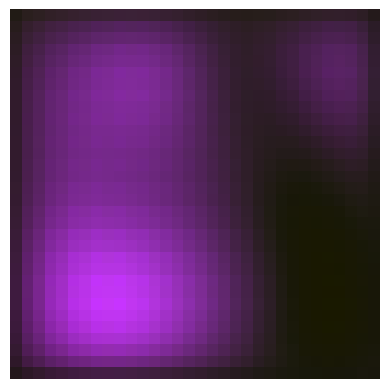

In [86]:
import torchvision.utils as vutils
def plot_image(image):
    '''
    Takes in an image and shows it using matplotlib 
    this is used to visualize the data and also the outputs of our network
    '''
    plt.figure()
    plt.imshow(vutils.make_grid(image.cpu(), padding=2, normalize=True).permute(1, 2, 0))
    plt.grid('off')
    plt.axis('off')
    plt.show()

plot_image(gan(torch.randn(1, 256, 1, 1, device=device)))

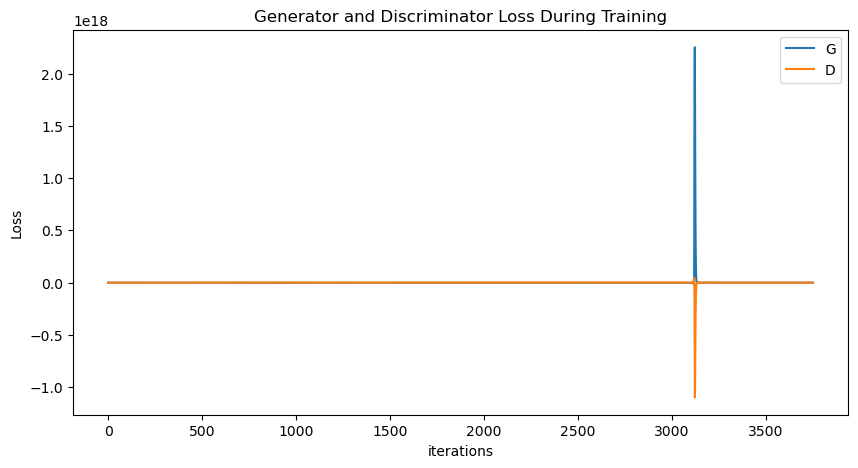

In [77]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()